In [3]:
%load_ext autoreload
%autoreload 2

# import importers
# import importlib
# importlib.reload(importers)
import importers
from importers import SpikeImporter

data_folder = "../data/"
file_name = "20_05_13_U1a_4960s_5400s"
file_ending = ".csv"

time_channel = "Time"
signal_channel = "1 Signal"
stimulus_channel = "32 DigMark"
ap_marker_channels = ["3 nw-1"]
extra_stimuli_channel = "801 DigMark"

# load the animal file
importer = SpikeImporter(filepath = data_folder + file_name + file_ending, time_channel = time_channel, signal_channel = signal_channel)

print("Data loaded.")

# define the max. time so that two sequential waveform-values are belonging to the same AP
# the time is in seconds, so 0.005 equals 5ms
max_gap_time = 0.005

# retrieve the events from the importer 
el_stimuli = importer.get_electrical_stimuli(regular_stimulus_channel = stimulus_channel)
el_extra_stimuli = importer.get_extra_stimuli(extra_stimulus_channel = extra_stimuli_channel, regular_el_stimuli = el_stimuli, verbose = True)
actpots = importer.get_action_potentials(max_gap_time = max_gap_time, ap_marker_channels = ap_marker_channels, \
                                      el_stimuli = el_stimuli, mech_stimuli = [], el_extra_stimuli = el_extra_stimuli, verbose = False)
# raw_signal = importer.get_raw_signal_split_by_stimuli(el_stimuli = el_stimuli, verbose = True)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Data loaded.
List of eletrical stimuli created.
Found el. stimulus signal at:
Time = 31.9963s
Found el. stimulus signal at:
Time = 32.19635s
Found el. stimulus signal at:
Time = 32.3964s
Found el. stimulus signal at:
Time = 32.5965s
Created electrical extra stimulus event:
From 31.9963s to 32.5965s.
#Pulses: 4
Frequency: 6.664445184938383Hz
Prepulse distance: 1.0012499999999989s

Found el. stimulus signal at:
Time = 63.9984s
Found el. stimulus signal at:
Time = 64.19845s
Found el. stimulus signal at:
Time = 64.3985s
Found el. stimulus signal at:
Time = 64.5986s
Created electrical extra stimulus event:
From 63.9984s to 64.5986s.
#Pulses: 4
Frequency: 6.664445184938264Hz
Prepulse distance: 1.0012499999999989s

Found el. stimulus signal at:
Time = 96.0005s
Found el. stimulus signal at:
Time = 96.20055s
Found el. stimulus signal at:
Time = 96.4006s
Found el. stimulus signal at:
Time = 96.6007s
Created e

In [4]:
''' 
This cell performs the clustering according to
- distance to previous stimulus
- normalized signal energy of the APs
'''
%autoreload 2
from metrics import clustering_metrics
from sklearn.cluster import DBSCAN
import numpy as np

# build feature vectors from the features provided by AP class
features = np.array([[ap.get_dist_to_prev_reg_el_stimulus(), ap.get_normalized_energy()] for ap in actpots])
channel_indices = np.array([ap.get_channel_index() for ap in actpots])
labels = DBSCAN(eps = 0.005, min_samples = 10, metric = clustering_metrics.time_dist_and_energy, metric_params = {'energy_importance': 0}).fit_predict(features)
print("Clustering done.")

Clustering done.


c:\users\fabia\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:36: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


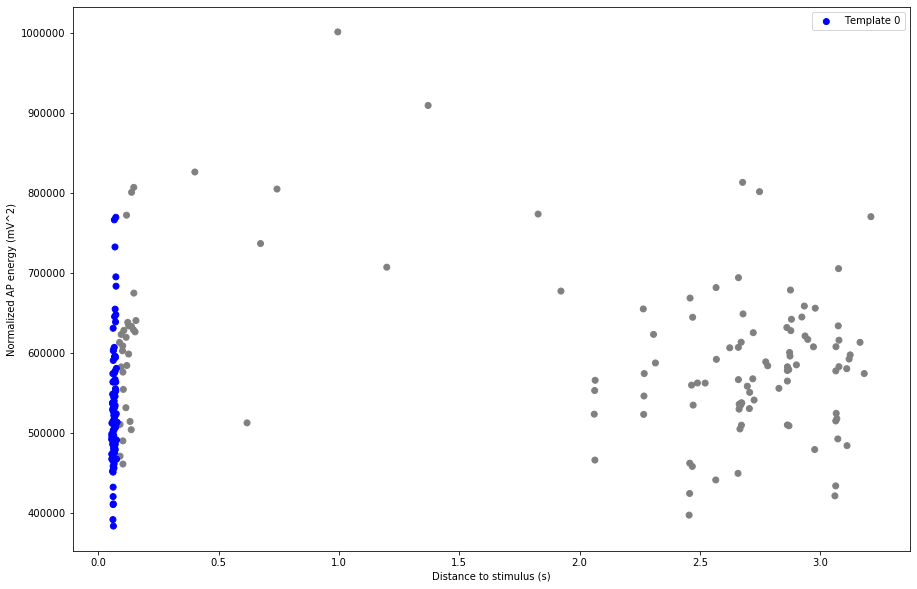

In [7]:
import matplotlib.pyplot as plt

markers = ['o', 'x', 's', 'D']
cluster_colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'gray']

# where to save the results
results_folder = "../results/"
results_ending = ".png"

# initialize figure
fig = plt.figure(figsize = (15, 10))

channel_index = 0
while channel_index <= max(channel_indices):
    # get a mask for all APs from this channel
    indices = (channel_indices == channel_index)
    
    # get the 'cut' list of features and the colors corresponding to their cluster membership
    channel_features = features[indices, :]
    colors = np.array([cluster_colors[label % len(cluster_colors)] for label in labels])
    colors = colors[indices]
    
    # plot APs with marker according to channel index
    plt.scatter(x = channel_features[:, 0], y = channel_features[:, 1], c = colors, marker = markers[channel_index], label = "Template " + str(channel_index))
    
    channel_index = channel_index + 1

    
plt.xlabel("Distance to stimulus (s)")
# plt.xscale('log')
# plt.xlim(0, 0.1)
# plt.xlim(0.24, 0.26)
plt.ylabel("Normalized AP energy (mV^2)")
plt.legend()

fig.show()
fig.savefig(results_folder + "dbscan_clustering_" + file_name + results_ending, dpi = 400)

Starting at 201.6086s
Cropped interval from 201.6086s to 205.60885s
Cropped interval from 205.60885s to 209.6091s
Cropped interval from 209.6091s to 213.60935s
Cropped interval from 213.60935s to 217.6096s
Cropped interval from 217.6096s to 221.6098s
Cropped interval from 221.6098s to 225.61035s
Cropped interval from 225.61035s to 229.6106s
Cropped interval from 229.6106s to 233.61085s
Cropped interval from 233.61085s to 237.6111s
Cropped interval from 237.6111s to 241.6113s
Cropped interval from 241.6113s to 245.61155s
Cropped interval from 245.61155s to 249.6118s
Cropped interval from 249.6118s to 253.61205s
Done with cropping the intervals


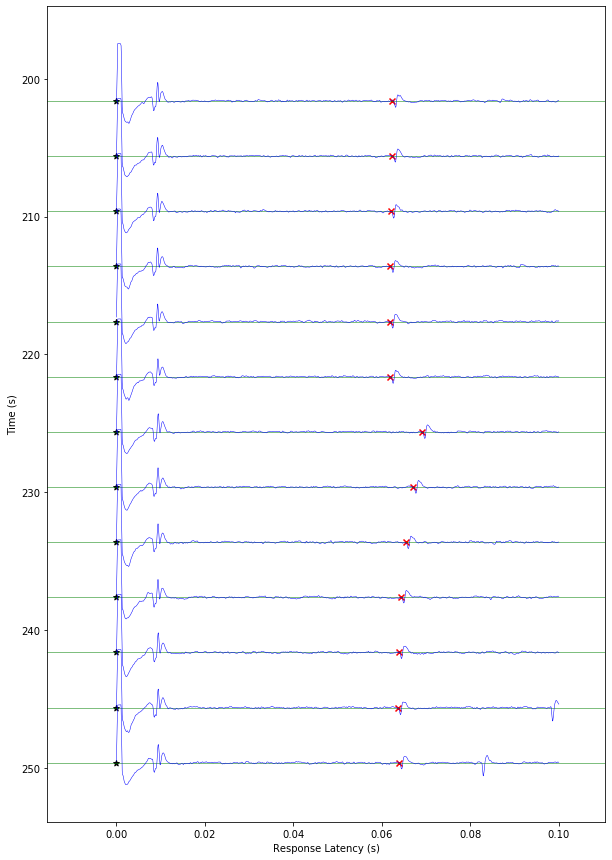

Figure saved.


In [8]:
%autoreload 2
from plotting import FallingLeafPlot
import itertools

analysis_start = 200
analysis_stop = 250

clusters_to_plot = [0]
indices = [(True if lbl in clusters_to_plot else False) for lbl in labels]
track_aps = list(itertools.compress(actpots, indices))

# get the raw signal from the data
raw_signal_intervals = importer.get_raw_signal_split_by_stimuli(el_stimuli = el_stimuli, start_time = analysis_start, stop_time = analysis_stop, verbose = True)
max_signal = max([max(interval) for interval in raw_signal_intervals])

flplot = FallingLeafPlot()
flplot.plot(regular_stimuli = el_stimuli, action_potentials = track_aps, plot_raw_signal = True, max_signal_value = max_signal, time_start = analysis_start, time_stop = analysis_stop, post_stimulus_timeframe = 0.1)
flplot.save_to_file(filename = "../results/falling_leaf_" + file_name + ".png")